In [2]:
import sys
import numpy as np 
sys.path.append('../../../src/')
sys.path.append('../../../src/wikidata')
from mask_dataset import MaskedDataset

dataset = MaskedDataset(model_name="mbert", reload=False)

Load pre-saved file /home/xzhao/workspace/probing-mulitlingual/result/dataset-mbert/mlama-dataset.pkl for MaskedDataset instance


In [19]:
from evaluate_tokenized_articles import get_wiki_matches_matrix_from_tokenized_wiki_article

all_absent_matches = []
uuid_info_plain = dataset.uuid_info_plain
langs, all_uuids, sub_matrix = get_wiki_matches_matrix_from_tokenized_wiki_article(dataset)
lang_idx, uuid_idx = np.where(sub_matrix==2)
for i in range(len(lang_idx)):
    uuid = all_uuids[uuid_idx[i]]
    lang = langs[lang_idx[i]]
    if lang == 0:
        print(uuid)
    all_absent_matches.append((lang, uuid_info_plain[uuid]['rel_uri'], uuid))


In [20]:
# Define the rels that are classified into naming cues 
# naming_rels = ['P103', 'P20', 'P17', 'P364', 'P37', 'P407', 'P19', 'P1412', 'P937', 'P1412', "P190", "P140", "P27"]
naming_rels = ["P17", "P27", "P1412", "P140", "P103"]
for rel in naming_rels:
    print(f"{rel}& {dataset.display_rel(rel)}\\\\")

P17& [X] is located in [Y] .\\
P27& [X] is [Y] citizen .\\
P1412& [X] used to communicate in [Y] .\\
P140& [X] is affiliated with the [Y] religion .\\
P103& The native language of [X] is [Y] .\\


In [21]:
from tqdm import tqdm
from zhconv import convert

uuid_info = dataset.get_uuid_info_all_lang()
sub_info = dataset.get_sub_info()
obj_info = dataset.get_obj_info()

def is_naming(rel):
    for naming_rel in naming_rels:
        if rel == naming_rel:
            return True
    else:
        return False
    
def is_token_overlap(lang, uuid):
    sub_tokens = sub_info[uuid_info[uuid][lang]['sub_uri']][lang]['sub_tokens']
    obj_tokens = obj_info[uuid_info[uuid][lang]['obj_uri']][lang]['obj_tokens']
    if lang != "zh":
        if set(sub_tokens).intersection(set(obj_tokens)):
            return True
    else:
        sub_tokens = [convert(sub, 'zh-cn') for sub in sub_tokens]
        obj_tokens = [convert(obj, 'zh-cn') for obj in obj_tokens]
        if set(sub_tokens).intersection(set(obj_tokens)):
            return True
    return False

def is_overlap(lang, uuid):
    sub = uuid_info[uuid][lang]['sub']
    obj = uuid_info[uuid][lang]['obj']
    if lang != "zh":
        if obj.lower() in sub.lower():
            return True
    else:
        sub = convert(sub, 'zh-cn')
        obj = convert(obj, 'zh-cn')
        if obj in sub:
            return True
    return False

naming = []
overlap = []
token_overlap = []
others = []

all_naming_rels = []
for lang, rel, uuid in tqdm(all_absent_matches):
    if is_overlap(lang, uuid):
        overlap.append([uuid, lang, dataset.display_uuid(uuid, lang=lang)]) 
    elif is_token_overlap(lang, uuid):
        token_overlap.append([uuid, lang, dataset.display_uuid(uuid, lang=lang)])     
    elif is_naming(rel):
        if rel not in all_naming_rels:
            print(f"{rel}& {dataset.display_rel(rel)} & {dataset.display_uuid(uuid)}\\\\")
            all_naming_rels.append(rel)
        naming.append([uuid, lang, dataset.display_uuid(uuid, lang=lang)]) 
    else:
        others.append([uuid, lang, dataset.display_uuid(uuid, lang=lang)]) 

100%|██████████| 14641/14641 [00:00<00:00, 114332.75it/s]

P103& The native language of [X] is [Y] . & The native language of Jean-Baptiste Say is French .\\
P17& [X] is located in [Y] . & Noyon is located in France .\\
P140& [X] is affiliated with the [Y] religion . & Abdullah Ahmad Badawi is affiliated with the Islam religion .\\
P1412& [X] used to communicate in [Y] . & Pere Gimferrer used to communicate in Spanish .\\
P27& [X] is [Y] citizen . & Giovanni Lista is Italy citizen .\\


In [22]:
# Define the rels that are classified into naming cues
import random
rel2naming_uuid = {}
uuid_info2 = dataset.get_uuid_info_plain()
for uuid, lang, sent in naming:
    rel_uri = uuid_info2[uuid]['rel_uri']
    rel2naming_uuid.setdefault(rel_uri, []).append([uuid, lang])

for rel in rel2naming_uuid:
    print(rel)
    uuids = random.choices(list(rel2naming_uuid[rel]), k=10)
    for uuid, lang in uuids:
        print(lang, dataset.display_uuid(uuid, lang=lang), '\t', dataset.display_uuid(uuid))

P103
zh 叶夫根尼雅·奥尔巴茨的母语是俄语。 	 The native language of Yevgenia Albats is Russian .
ca La llengua nativa de Louis de Carmontelle és francès. 	 The native language of Louis Carrogis Carmontelle is French .
da Mødesproget til Laurent Stocker er fransk. 	 The native language of Laurent Stocker is French .
nl De moedertaal van Christian Bouchet is Frans. 	 The native language of Christian Bouchet is French .
da Mødesproget til Christophe Hondelatte er fransk. 	 The native language of Christophe Hondelatte is French .
da Mødesproget til Eustache-Hyacinthe Langlois er fransk. 	 The native language of Eustache-Hyacinthe Langlois is French .
da Mødesproget til Jean-Marie Cavada er fransk. 	 The native language of Jean-Marie Cavada is French .
hr Izvorni jezik Yvonne Monlaur je francuski jezik. 	 The native language of Yvonne Monlaur is French .
bg Родният език на Луи Барту е френски език. 	 The native language of Louis Barthou is French .
ca La llengua nativa de Gustave Geffroy és francès. 	 The n

In [23]:
# Display all facts that are predicted through overlapping tokens (not subset)
for uuid, lang, sent in token_overlap:
    print(f"Sentence: {dataset.display_uuid(uuid, lang=lang)}, Subject: {uuid_info[uuid][lang]['sub']}, Object: {uuid_info[uuid][lang]['obj']}")

Sentence: Адэскі заліў названы ў гонар Адэса., Subject: Адэскі заліў, Object: Адэса
Sentence: Венециански филмов фестивал се намира в Венеция., Subject: Венециански филмов фестивал, Object: Венеция
Sentence: ব্র্যতাইন ব্রতাইন এর একটি অংশ।, Subject: ব্র্যতাইন, Object: ব্রতাইন
Sentence: Sídlo Pontifikální katolická univerzita v Chile je v Santiago de Chile., Subject: Pontifikální katolická univerzita v Chile, Object: Santiago de Chile
Sentence: Oficiální jazyk Španělsko v době osvícenství je španělština., Subject: Španělsko v době osvícenství, Object: španělština
Sentence: Oficiální jazyk Francouzská jižní a antarktická území je francouzština., Subject: Francouzská jižní a antarktická území, Object: francouzština
Sentence: Samsung Life Insurance ist Teil von Samsung Group., Subject: Samsung Life Insurance, Object: Samsung Group
Sentence: ویکی‌پدیای چکی در زبان چکی نوشته شده است., Subject: ویکی‌پدیای چکی, Object: زبان چکی
Sentence: اَدوبی فوتوشاپ توسط ادوبی توسعه یافته است., Subject: اَدو

In [24]:
# The numbers of different types of facts
print(f"overlap: {len(overlap)}")
print(f"token_overlap: {len(token_overlap)}")
print(f"naming: {len(naming)}")
print(f"others: {len(others)}")


overlap: 3731
token_overlap: 52
naming: 3214
others: 7644


In [25]:
# Display of a part of the facts in "other types", only displaying the English version of facts. 
import random
for uuid, lang, raw_sent in random.choices(others, k=20):
    uuid_info = dataset.uuid_info_all_lang[uuid][lang]
    print(f"{uuid}, {lang}, {uuid_info['rel_uri']}, {uuid_info['sub']}, {uuid_info['obj']}, {dataset.display_uuid(uuid, lang='en')}")

1b35de71-b137-4a56-b2d8-eb7813d82ecd, da, P19, Franciszek Smuglewicz, Warszawa, Franciszek Smuglewicz was born in Warsaw .
98f03a6b-a27b-491e-931f-d0d6766d6cd0, es, place_of_birth, François Lehideux, París, François Lehideux was born in Paris .
9b7f4673-aec6-4efe-aa3f-de900e4da870, id, P937, Richard Brinsley Sheridan, London, Richard Brinsley Sheridan used to work in London .
bcb73f42-e9f4-4896-b71c-779e715a71a6, pt, P937, Marco Pannella, Roma, Marco Pannella used to work in Rome .
6c92275f-b3a2-4cc8-932c-e4956f38b50e, de, place_of_birth, Gerard Hemsworth, London, Gerard Hemsworth was born in London .
689eca2e-8f72-4b34-973f-5ae7c247c793, sq, P937, Georges Aperghis, Paris, Georges Aperghis used to work in Paris .
7d231784-de86-4d4e-a5a3-7de70375ccd2, sv, P361, elementär aritmetik, matematik, elementary arithmetic is part of mathematics .
d46c33d7-ddfd-4008-a4f1-747ad806afc1, hr, P37, Aarau, njemački jezik, The official language of Aarau is German .
5cbc33f6-5644-4efe-827c-dda2ae277d52,

In [26]:
import token
import pandas as pd

sorted_langs = ['en', 'id', 'it', 'de', 'es', 'nl', 'pt', 'ca', 'tr', 'da', 'ms', 'sv', 'fr', 'af', 'ro', 'vi', 'gl', 'fa', 'cy', 'el', 'he', 'ko', 
                 'zh', 'pl', 'ar', 'hu', 'hr', 'cs', 'ceb', 'et', 'sq', 
                 'sk', 'bg', 'ur', 'uk', 'fi', 'hy', 'sr', 'hi', 'be', 'eu', 'lv', 'az', 'ru', 'bn', 'ka', 'ja', 'sl', 'lt', 'la', 'ga', 'ta', 'th']
lang2counts = {}

for sorted_lang in sorted_langs:
    lang2counts[sorted_lang] = {}

for uuid, lang, raw_sent in others:
    if 'other' in lang2counts[lang]:
        lang2counts[lang]['other'] += 1
    else:
        lang2counts[lang]['other'] = 1

for uuid, lang, raw_sent in naming:
    if 'naming' in lang2counts[lang]:
        lang2counts[lang]['naming'] += 1
    else:
        lang2counts[lang]['naming'] = 1

for uuid, lang, raw_sent in overlap:
    if 'overlap' in lang2counts[lang]:
        lang2counts[lang]['overlap'] += 1
    else:
        lang2counts[lang]['overlap'] = 1

for uuid, lang, raw_sent in token_overlap:
    if 'overlap' in lang2counts[lang]:
        lang2counts[lang]['overlap'] += 1
    else:
        lang2counts[lang]['overlap'] = 1

lang_types = []
for lang in sorted_langs:
    types = {
        "lang": lang,
        "naming": lang2counts[lang]['naming'] if 'naming' in lang2counts[lang] else 0,
        "shared_tokens": lang2counts[lang]['overlap'] if 'overlap' in lang2counts[lang] else 0,
        "others": lang2counts[lang]['other'] if 'other' in lang2counts[lang] else 0
        }
    lang_types.append(types)

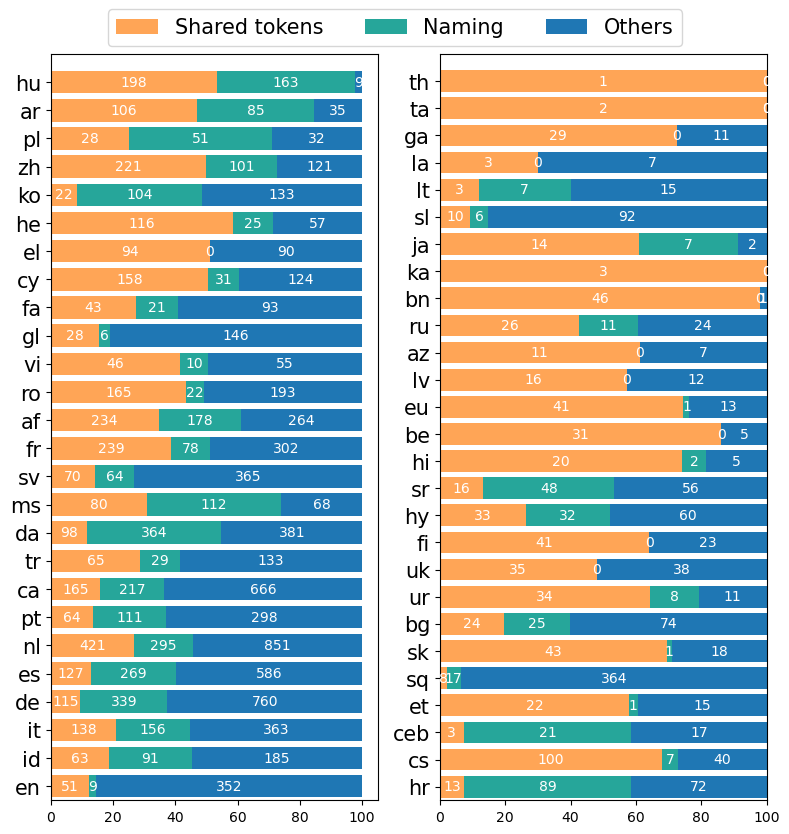

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import copy
import matplotlib
plt.rcParams['font.family'] = 'Times New Roman'

# matplotlib.rcParams['ps.useafm'] = True
# matplotlib.rcParams['pdf.use14corefonts'] = True
# matplotlib.rcParams['text.usetex'] = True

# Sample data
data = copy.deepcopy(lang_types)

green = "#26a69a"
orange = "#FF7F0EB3"
blue = "#1f77b4"
height = 0.7



# Extract values for plotting
# langs = [dataset.display_lang(item['lang'], prefix=False) for item in data]
langs = [item['lang'] for item in data]
naming2 = np.array([item['naming'] for item in data])
shared_tokens = np.array([item['shared_tokens'] for item in data])
others_cnt = np.array([item['others'] for item in data])
total = naming2 + shared_tokens + others_cnt

# Calculate percentages
naming_percent = naming2 / total * 100
shared_tokens_percent = shared_tokens / total * 100
others_percent = others_cnt / total * 100

# Split data into two halves
mid_idx = len(langs) // 2
langs1, langs2 = langs[:mid_idx], langs[mid_idx:]
naming_percent1, naming_percent2 = naming_percent[:mid_idx], naming_percent[mid_idx:]
shared_tokens_percent1, shared_tokens_percent2 = shared_tokens_percent[:mid_idx], shared_tokens_percent[mid_idx:]
others_percent1, others_percent2 = others_percent[:mid_idx], others_percent[mid_idx:]

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), sharey=False)

# Plotting on the left subplot
ax1.barh(langs1, shared_tokens_percent1,  color=orange, label='Shared tokens')
ax1.barh(langs1, naming_percent1, left=shared_tokens_percent1, color=green, label='Naming')
ax1.barh(langs1, others_percent1, left=naming_percent1 + shared_tokens_percent1, color=blue, label='Others')

# Annotate with actual values on the left subplot
for i, lang in enumerate(langs1):
    ax1.text(shared_tokens_percent[i]/2, i, str(shared_tokens[i]), va='center', ha='center', color='white')
    ax1.text(shared_tokens_percent[i] + naming_percent[i]/2, i, str(naming2[i]), va='center', ha='center', color='white')
    ax1.text(naming_percent[i] + shared_tokens_percent[i] + others_percent[i]/2, i, str(others_cnt[i]), va='center', ha='center', color='white')

# Plotting on the right subplot
ax2.barh(langs2, shared_tokens_percent2, color=orange)
ax2.barh(langs2, naming_percent2, left=shared_tokens_percent2, color=green)
ax2.barh(langs2, others_percent2, left=naming_percent2 + shared_tokens_percent2, color=blue)

# Annotate with actual values on the right subplot
for i, lang in enumerate(langs2):
    idx = i + mid_idx
    ax2.text(shared_tokens_percent[idx]/2, i, str(shared_tokens[idx]), va='center', ha='center', color='white')
    ax2.text(shared_tokens_percent[idx] + naming_percent[idx]/2, i, str(naming2[idx]), va='center', ha='center', color='white')
    ax2.text(naming_percent[idx] + shared_tokens_percent[idx] + others_percent[idx]/2, i, str(others_cnt[idx]), va='center', ha='center', color='white')

# Set title and legend
ax1.invert_yaxis()  # Reverse the order for the left subplot
ax2.invert_yaxis()
ax1.set_ylim(-0.5, len(langs1))
ax2.set_ylim(-0.5, len(langs2))
ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)  
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=15)
plt.tight_layout()
plt.savefig('../../display/figures/three_types.eps', format="eps", transparent=True, dpi=1000, bbox_inches="tight")

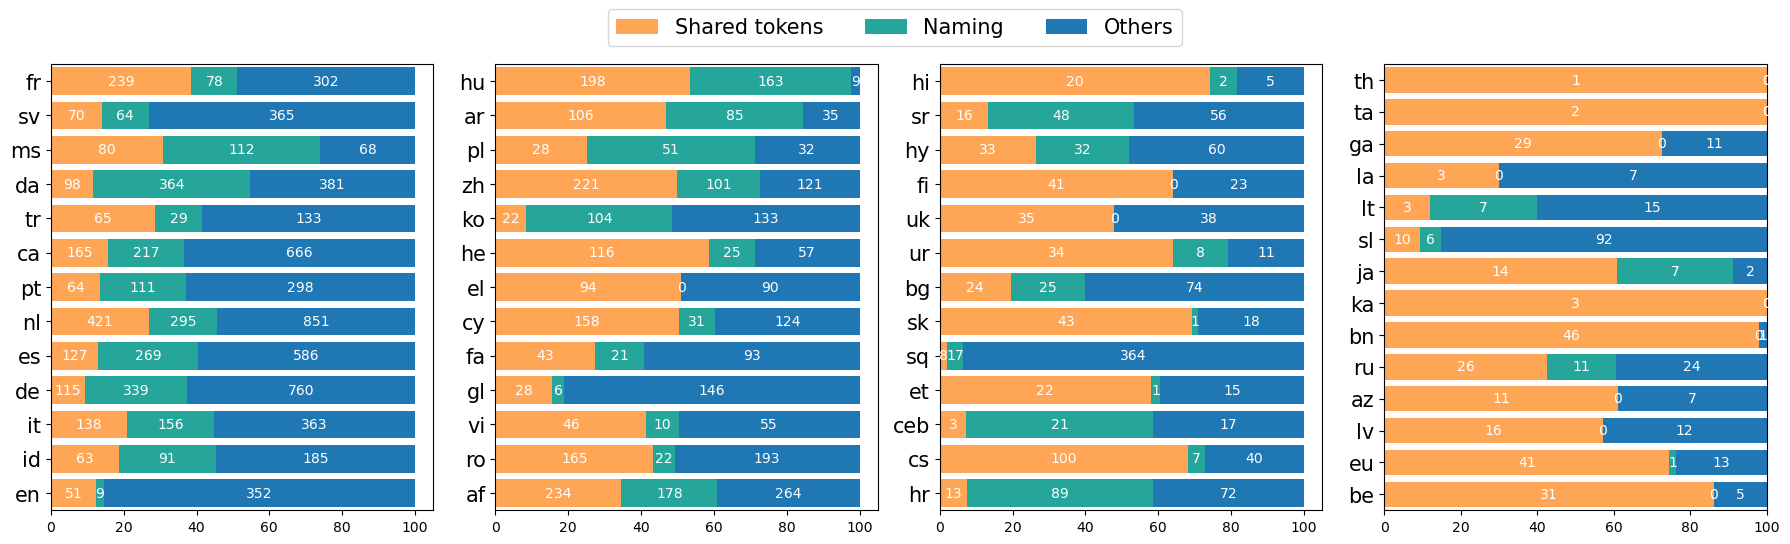

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import copy

# Assuming data is pre-defined as per your previous setup
data = copy.deepcopy(lang_types)  # Make sure lang_types is defined

# Colors, heights, and other configurations
green = "#26a69a"
orange = "#FF7F0EB3"
blue = "#1f77b4"

# Extract values for plotting
langs = [item['lang'] for item in data]
naming3 = np.array([item['naming'] for item in data])
shared_tokens3 = np.array([item['shared_tokens'] for item in data])
others_cnt3 = np.array([item['others'] for item in data])
total = naming3 + shared_tokens3 + others_cnt3

# Calculate percentages
naming_percent3 = naming3 / total * 100
shared_tokens_percent3 = shared_tokens3 / total * 100
others_percent3 = others_cnt3 / total * 100

# Split data into six parts
parts = 4  # Number of columns
per_part = len(langs) // parts  # Number of languages per column
lang_parts, naming_parts, shared_parts, others_parts = [], [], [], []
for i in range(parts):
    if i < parts-1:
        lang_parts.append(langs[i * per_part:(i + 1) * per_part])
        naming_parts.append(naming_percent3[i * per_part:(i + 1) * per_part])
        shared_parts.append(shared_tokens_percent3[i * per_part:(i + 1) * per_part])
        others_parts.append(others_percent3[i * per_part:(i + 1) * per_part])
    else:
        lang_parts.append(langs[i * per_part:])
        naming_parts.append(naming_percent3[i * per_part:])
        shared_parts.append(shared_tokens_percent3[i * per_part:])
        others_parts.append(others_percent3[i * per_part:])

# Create six subplots side by side
fig, axes = plt.subplots(1, parts, figsize=(18, 5), sharey=False)  # Adjust figsize as needed

# Plotting on each subplot
for i in range(parts):
    if i == 0:
        axes[i].barh(lang_parts[i], shared_parts[i], color=orange, label='Shared tokens')
        axes[i].barh(lang_parts[i], naming_parts[i], left=shared_parts[i], color=green, label='Naming')
        axes[i].barh(lang_parts[i], others_parts[i], left=naming_parts[i] + shared_parts[i], color=blue, label='Others')
    else:
        axes[i].barh(lang_parts[i], shared_parts[i], color=orange)
        axes[i].barh(lang_parts[i], naming_parts[i], left=shared_parts[i], color=green)
        axes[i].barh(lang_parts[i], others_parts[i], left=naming_parts[i] + shared_parts[i], color=blue)

    # Annotate with actual values on each subplot
    for j, lang in enumerate(lang_parts[i]):
        idx = i * per_part + j
        axes[i].text(shared_tokens_percent3[idx] / 2, j, str(shared_tokens3[idx]), va='center', ha='center', color='white')
        axes[i].text(shared_tokens_percent3[idx] + naming_percent3[idx] / 2, j, str(naming3[idx]), va='center', ha='center', color='white')
        axes[i].text(naming_percent3[idx] + shared_tokens_percent3[idx] + others_percent3[idx] / 2, j, str(others_cnt3[idx]), va='center', ha='center', color='white')
    axes[i].invert_yaxis()
    axes[i].set_ylim(-0.5, len(lang_parts[i]) - 0.5)
    axes[i].tick_params(axis='y', labelsize=15)

# Set legend and tight_layout
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fontsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('../../display/figures/three_types.eps', format="eps", transparent=True, dpi=1000, bbox_inches="tight")


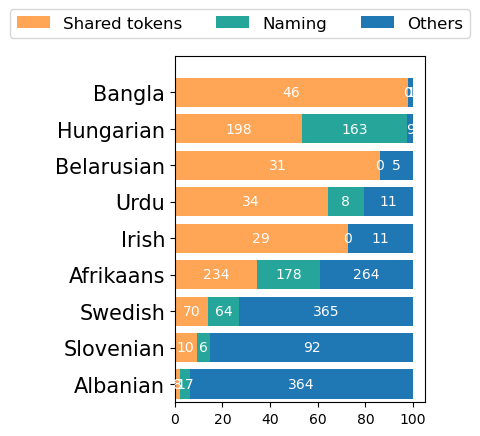

In [66]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import copy
import matplotlib
plt.rcParams['font.family'] = 'Times New Roman'

# matplotlib.rcParams['ps.useafm'] = True
# matplotlib.rcParams['pdf.use14corefonts'] = True
# matplotlib.rcParams['text.usetex'] = True

# Sample data
lang2data = {}
for lang in sorted_langs:
    lang2data[lang] = {
        "naming": lang2counts[lang]['naming'] if 'naming' in lang2counts[lang] else 0,
        "shared_tokens": lang2counts[lang]['overlap'] if 'overlap' in lang2counts[lang] else 0,
        "others": lang2counts[lang]['other'] if 'other' in lang2counts[lang] else 0
        }
    lang_types.append(types)

data = copy.deepcopy(lang_types)

green = "#26a69a"
orange = "#FF7F0EB3"
blue = "#1f77b4"
height = 0.7



# Extract values for plotting
# langs = [dataset.display_lang(item['lang'], prefix=False) for item in data]
# langs = [item['lang'] for item in data]
highlighted_languages = [dataset.display_lang(lang, False) for lang in ['af', 'it', 'ja']]
langs1 = ['sq', 'sl', 'sv', 'af', 'ga', 'ur', 'be', 'hu', 'bn']
# langs1 = ['en', 'es', 'it', 'af', 'sq', 'cy', 'sk', 'et', 'ja']
langs_names = [dataset.display_lang(lang, False) for lang in langs1]
naming2 = np.array([lang2data[lang]['naming'] for lang in langs1])
shared_tokens = np.array([lang2data[lang]['shared_tokens'] for lang in langs1])
others_cnt = np.array([lang2data[lang]['others'] for lang in langs1])

total = naming2 + shared_tokens + others_cnt

# Calculate percentages
naming_percent = naming2 / total * 100
shared_tokens_percent = shared_tokens / total * 100
others_percent = others_cnt / total * 100

# Split data into two halves
# naming_percent1, naming_percent2 = naming_percent[:mid_idx], naming_percent[mid_idx:]
# shared_tokens_percent1, shared_tokens_percent2 = shared_tokens_percent[:mid_idx], shared_tokens_percent[mid_idx:]
# others_percent1, others_percent2 = others_percent[:mid_idx], others_percent[mid_idx:]

# Create two subplots side by side
fig, ax1 = plt.subplots(figsize=(4, 4))

# Plotting on the left subplot
ax1.barh(langs_names, shared_tokens_percent,  color=orange, label='Shared tokens')
ax1.barh(langs_names, naming_percent, left=shared_tokens_percent, color=green, label='Naming')
ax1.barh(langs_names, others_percent, left=naming_percent + shared_tokens_percent, color=blue, label='Others')

# for tick in ax1.get_yticklabels():
#     if tick.get_text() in highlighted_languages:
#         tick.set_color('r')
#         tick.set_fontweight('bold')

# Annotate with actual values on the left subplot
for i, lang in enumerate(langs_names):
    ax1.text(shared_tokens_percent[i]/2, i, str(shared_tokens[i]), va='center', ha='center', color='white')
    ax1.text(shared_tokens_percent[i] + naming_percent[i]/2, i, str(naming2[i]), va='center', ha='center', color='white')
    ax1.text(naming_percent[i] + shared_tokens_percent[i] + others_percent[i]/2, i, str(others_cnt[i]), va='center', ha='center', color='white')

# Set title and legend
# ax1.invert_yaxis()  # Reverse the order for the left subplot
ax1.set_ylim(-0.5, len(langs_names))
ax1.tick_params(axis='y', labelsize=15)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fontsize=12)
plt.tight_layout()
plt.savefig('../../display/figures/three_types.eps', format="eps", transparent=True, dpi=1000, bbox_inches="tight")

In [14]:
others_df = pd.DataFrame()
failed_lang = ["Arabic", "Bangla", "Persian", "Hebrew", "Hindi", "Armenian", "Urdu"]
packed = [] 
for uuid, lang, raw_sent in others:
    if lang in packed or dataset.display_lang(lang, prefix=False) in failed_lang:
        continue
    temp_df = pd.DataFrame({"Language": [dataset.display_lang(lang, prefix=False)], 
                            "Absent & Predictable fact": [dataset.display_uuid(uuid, lang=lang)]})
    others_df = pd.concat([others_df, temp_df], ignore_index=True)
    packed.append(lang)

naming_df = pd.DataFrame()
packed = [] 
for uuid, lang, raw_sent in naming:
    if lang in packed or dataset.display_lang(lang, prefix=False) in failed_lang:
        continue
    temp_df = pd.DataFrame({"Language": [dataset.display_lang(lang, prefix=False)], 
                            "Absent & Predictable fact": [dataset.display_uuid(uuid, lang=lang)]})
    naming_df = pd.concat([naming_df, temp_df], ignore_index=True)
    packed.append(lang)


overlap_df = pd.DataFrame()
packed = [] 
for uuid, lang, raw_sent in overlap:
    if lang in packed or dataset.display_lang(lang, prefix=False) in failed_lang:
        continue
    temp_df = pd.DataFrame({"Language": [dataset.display_lang(lang, prefix=False)], 
                            "Absent & Predictable fact": [dataset.display_uuid(uuid, lang=lang)]})
    overlap_df = pd.concat([overlap_df, temp_df], ignore_index=True)
    packed.append(lang)

In [15]:
overlap_df.to_csv("overlap_df.csv")
naming_df.to_csv("naming_df.csv")
others_df.to_csv("others_df.csv")

In [16]:
for lang, fact in zip(*[naming_df['Language'].tolist(), naming_df['Absent & Predictable fact'].tolist()]):
    print(f"{lang} & {fact}\\\\")

Afrikaans & Die moedertaal van Jean-Baptiste Say is Frans.\\
Bulgarian & Родният език на Лионел Жоспен е френски език.\\
Catalan & La llengua nativa de Alain Mabanckou és francès.\\
Cebuano & Ang Giovanni Lista usa ka lungsuranon sa Italya.\\
Czech & Rodný jazyk Danielle Darrieuxová je francouzština.\\
Welsh & Mae Guillaumes wedi'i leoli yn Ffrainc.\\
Danish & Mødesproget til Pierre Blanchar er fransk.\\
German & Die Muttersprache von Pierre Blanchar ist Französisch.\\
English & The native language of Hamidou Benmassoud is French .\\
Spanish & Bruno Racine solía comunicarse en francés.\\
Estonian & Dominic Seiterle on Kanada kodanik.\\
Basque & Umar II.a Islam erlijioarekin erlazionatuta dago.\\
French & Bayazid Bastami est affilié à la religion islam.\\
Galician & Toulouges está situado en Francia.\\
Croatian & Izvorni jezik Jean-Baptiste Say je francuski jezik.\\
Hungarian & John Hutton az angol nyelven történő kommunikációhoz használt.\\
Indonesian & Adrian Knox adalah warga negara 